In [10]:
import torch
from torch_geometric_temporal.nn.recurrent import A3TGCN
import numpy as np
from torch_geometric_temporal import DynamicGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric.utils import dense_to_sparse

In [11]:
node_features = np.load("../data/node_features.npz")
edge_features = np.load("../data/edge_features.npz")

X, y = node_features["X"], node_features["y"]
A = edge_features["A"]

In [17]:
edge_indices = []
edge_weights = []
features = []
targets = []

for i in range(len(X)):
    indices, weights = dense_to_sparse(torch.from_numpy(A[i].mean(axis=0)))
    feature = X[i].reshape(X[0].shape[0], -1).swapaxes(0, 1)
    target = y[i].ravel()
    
    edge_indices.append(indices.numpy())
    edge_weights.append(weights.numpy())
    features.append(feature)
    targets.append(target)

In [18]:
k8s_dataset = DynamicGraphTemporalSignal(edge_indices, edge_weights, features, targets)
train_dataset, test_dataset = temporal_signal_split(k8s_dataset, train_ratio=0.8)

In [19]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, dim_in, hidde_channels, periods):
        super().__init__()
        self.tgnn = A3TGCN(in_channels=dim_in, out_channels=hidde_channels, periods=periods)
        self.linear = torch.nn.Linear(hidde_channels, periods)
    
    def forward(self, x, edge_index, edge_attr):
        h = self.tgnn(x, edge_index, edge_attr).relu()
        h = self.linear(h)
        return h

In [20]:
%%time
model = TemporalGNN(12, 128, 1).to('cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

history = []
model.train()
for epoch in range(500):
    loss = 0
    step = 0
    for i, snapshot in enumerate(train_dataset):
        y_pred = model(snapshot.x.unsqueeze(2), snapshot.edge_index, snapshot.edge_attr)
        loss += torch.mean((y_pred - snapshot.y) ** 2)
        step += 1
    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    history.append(loss.item())
    if epoch % 10 == 0:
     print(f"Epoch {epoch+1:>2} | Train MSE: {loss:.4f}")

Epoch  1 | Train MSE: 0.8974
Epoch 11 | Train MSE: 0.8773
Epoch 21 | Train MSE: 0.8722
Epoch 31 | Train MSE: 0.8682
Epoch 41 | Train MSE: 0.8650
Epoch 51 | Train MSE: 0.8620
Epoch 61 | Train MSE: 0.8591
Epoch 71 | Train MSE: 0.8562
Epoch 81 | Train MSE: 0.8532
Epoch 91 | Train MSE: 0.8501
Epoch 101 | Train MSE: 0.8474
Epoch 111 | Train MSE: 0.8452
Epoch 121 | Train MSE: 0.8430
Epoch 131 | Train MSE: 0.8415
Epoch 141 | Train MSE: 0.8390
Epoch 151 | Train MSE: 0.8369
Epoch 161 | Train MSE: 0.8363
Epoch 171 | Train MSE: 0.8339
Epoch 181 | Train MSE: 0.8321
Epoch 191 | Train MSE: 0.8317
Epoch 201 | Train MSE: 0.8298
Epoch 211 | Train MSE: 0.8280
Epoch 221 | Train MSE: 0.8295
Epoch 231 | Train MSE: 0.8259
Epoch 241 | Train MSE: 0.8246
Epoch 251 | Train MSE: 0.8278
Epoch 261 | Train MSE: 0.8229
Epoch 271 | Train MSE: 0.8218
Epoch 281 | Train MSE: 0.8214
Epoch 291 | Train MSE: 0.8217
Epoch 301 | Train MSE: 0.8197
Epoch 311 | Train MSE: 0.8185
Epoch 321 | Train MSE: 0.8175
Epoch 331 | Train MS

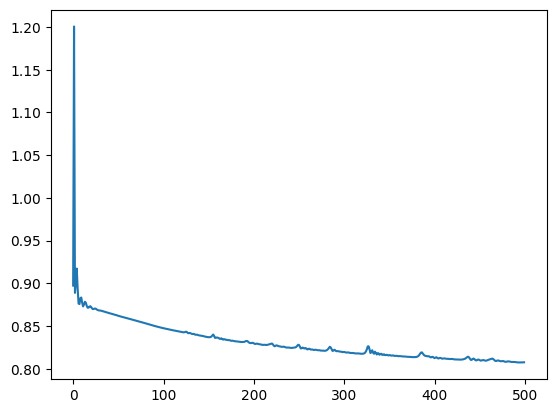

In [21]:
import matplotlib.pyplot as plt

plt.plot(history)

In [25]:
y_test = []
p_test = []
for (x, edge_index, edge_attr, y) in train_dataset:
    y_test.append(y[1].numpy())
    p_test.append(
        model(x[1].unsqueeze(2), edge_index[1], edge_attr[1]).detach().numpy().ravel()
    )
y_test = np.vstack(y_test)
p_test = np.vstack(p_test)

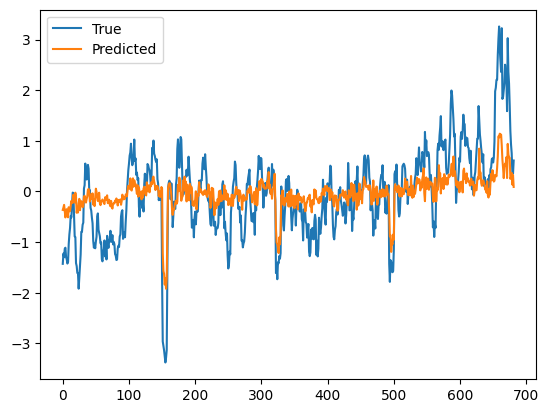

In [32]:
plt.plot(y_test[:, 4], label="True")
plt.plot(p_test[:, 4], label="Predicted")
plt.legend();